## Bike Sharing Analysis

#### Understanding the data - 1

In [1]:
#import the necessary libraries

# base library for EDA and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ml libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
#read the data from csv and check the shape

bike_df = pd.read_csv('day.csv')
bike_df.shape

(730, 16)

In [3]:
#check the first few lines of the dataset

bike_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


#### Peforming EDA on the dataset

In [4]:
#check the information about the columns

bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [5]:
#Check if there are any null rows  in data

bike_df.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

Based on the information provided in the dataset's column info, the columns <b><i>casual, registered, instant, dteday</i></b> are not needed


In [6]:
# instant is only an index 
# dteday is redundant as other columns like year, weekday and month also gives the same information
# casual and registered are just a breakup for the total count

columns_not_needed = ['casual','registered','instant','dteday']
bike_df.drop(columns_not_needed,axis=1,inplace=True)
bike_df.shape

(730, 12)

In [7]:
#encoding the season column to make it categorical

bike_df['season'] = bike_df['season'].map({1:'spring',2:'summer',3:'fall',4:'winter'})

In [8]:
#encoding the weathersit column to make it categorical

bike_df['weathersit'] = bike_df['weathersit'].map({1:'clear',2:'misty',3:'light rain',4:'heavy rain'})

In [9]:
#renaming the columns for better readability

bike_df.rename(columns={'weathersit':'weather_type','yr':'year','mnth':'month','atemp':'temp_feel','hum':'humidity','cnt':'count'},inplace=True)

In [10]:
#change the weekdays from numbers to make it categorical

bike_df['weekday'] = bike_df['weekday'].map({0:'sun',1:'mon',2:'tue',3:'wed',4:'thu',5:'fri',6:'sat'})

In [11]:
#change the months from numbers to make it categorical

bike_df['month'] = bike_df['month'].map({1:'jan',2:'feb',3:'mar',4:'apr',5:'may',6:'june',7:'july',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'})

In [12]:
#check the info

bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        730 non-null    object 
 1   year          730 non-null    int64  
 2   month         730 non-null    object 
 3   holiday       730 non-null    int64  
 4   weekday       730 non-null    object 
 5   workingday    730 non-null    int64  
 6   weather_type  730 non-null    object 
 7   temp          730 non-null    float64
 8   temp_feel     730 non-null    float64
 9   humidity      730 non-null    float64
 10  windspeed     730 non-null    float64
 11  count         730 non-null    int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 68.6+ KB


Checking for outliers in the numerical fields using Univariate Analysis on each column

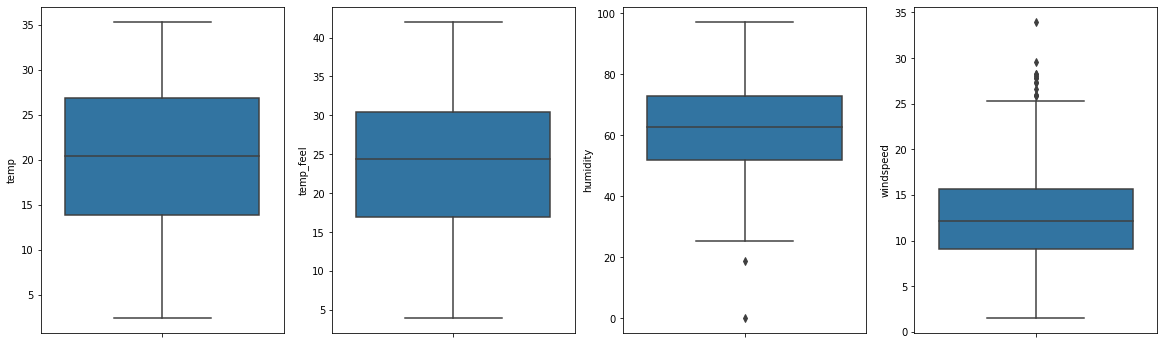

In [13]:
#check for any outliers

num_cols = ['temp', 'temp_feel', 'humidity', 'windspeed']

i=1
plt.figure(figsize=(20,6))
for col in num_cols:
    plt.subplot(1,4,i)
    sns.boxplot(y=col,data=bike_df)
    i+=1
plt.show()

Based on the above plots, we can confirm that there are no outliers in the data.

Now, let's perform a analysis to observe the distribution of count data based on different parameters across the years.

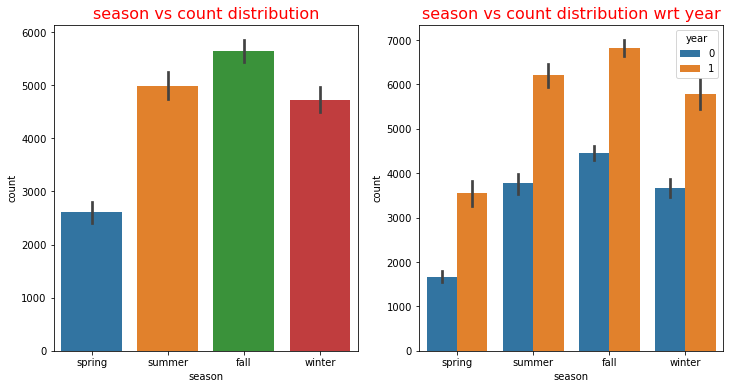

In [14]:
# Based on the above inferences let's try to analyze the data across year data

def PrintColVsCountPlot(col):
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    sns.barplot(col,'count',data=bike_df)
    cur_title = col+" vs count distribution"
    plt.title(cur_title,fontsize=16,color='r')
    plt.subplot(1,2,2)
    ax = sns.barplot(col,'count',data=bike_df, hue='year')
    cur_title = col+" vs count distribution wrt year"
    plt.title(cur_title,fontsize=16,color='r')
    plt.show()

PrintColVsCountPlot('season')

##### Inference

- The Fall season had the highest booking
- The year 2019 saw more bookings than 2018

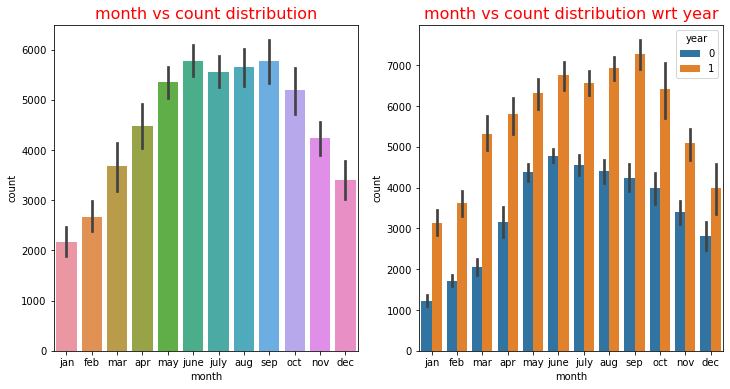

In [15]:
PrintColVsCountPlot('month')

##### Inference

- The month of June, July, August and September has the highest booking
- This could suggest the fall season is around these months

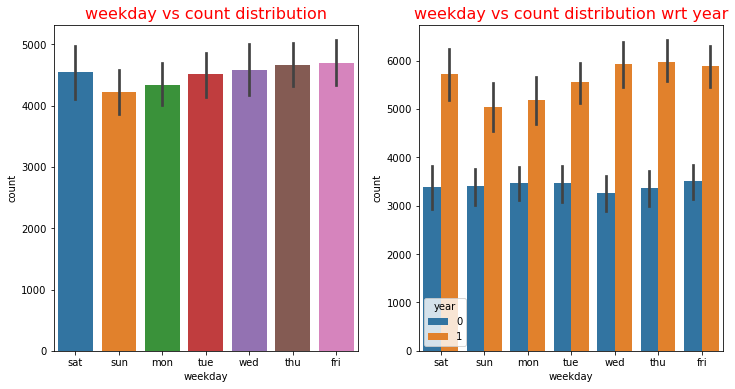

In [16]:
PrintColVsCountPlot('weekday')

##### Inference

- The bookings were mostly evenly distributed across the days, except sundays where the bookings were little lesser than other days.

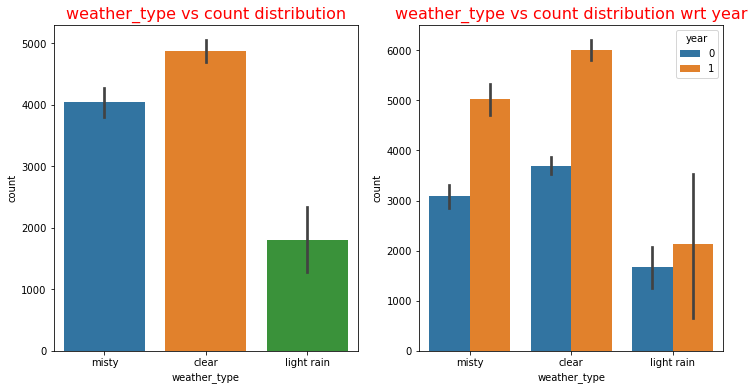

In [17]:
PrintColVsCountPlot('weather_type')

##### Inference

- The bookings are usually high on a 'Clear' weather day
- The bookings drop substantially on a 'Rainy' day

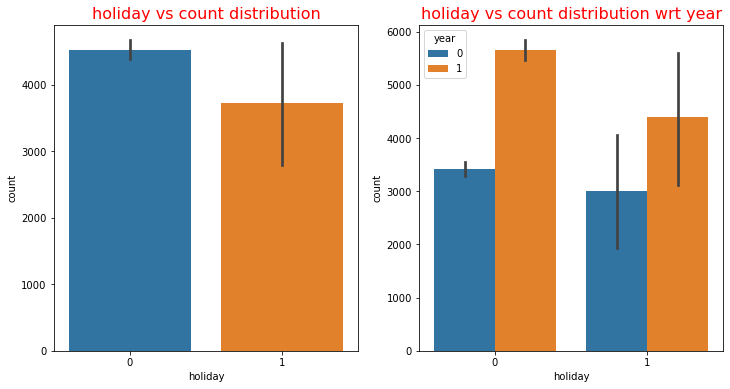

In [18]:
PrintColVsCountPlot('holiday')

##### Inference

- The bookings are a little lesser during a holiday when compared to non-holiday days.

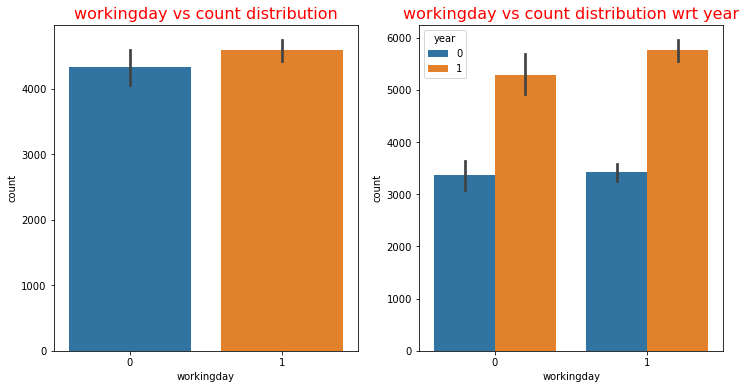

In [19]:
PrintColVsCountPlot('workingday')

##### Inference

- The bookings are almost the same for a 'working day' when compared to a 'non working day'

Now, let's check a pairplot to see if we can find up some pattern

<Figure size 1152x1152 with 0 Axes>

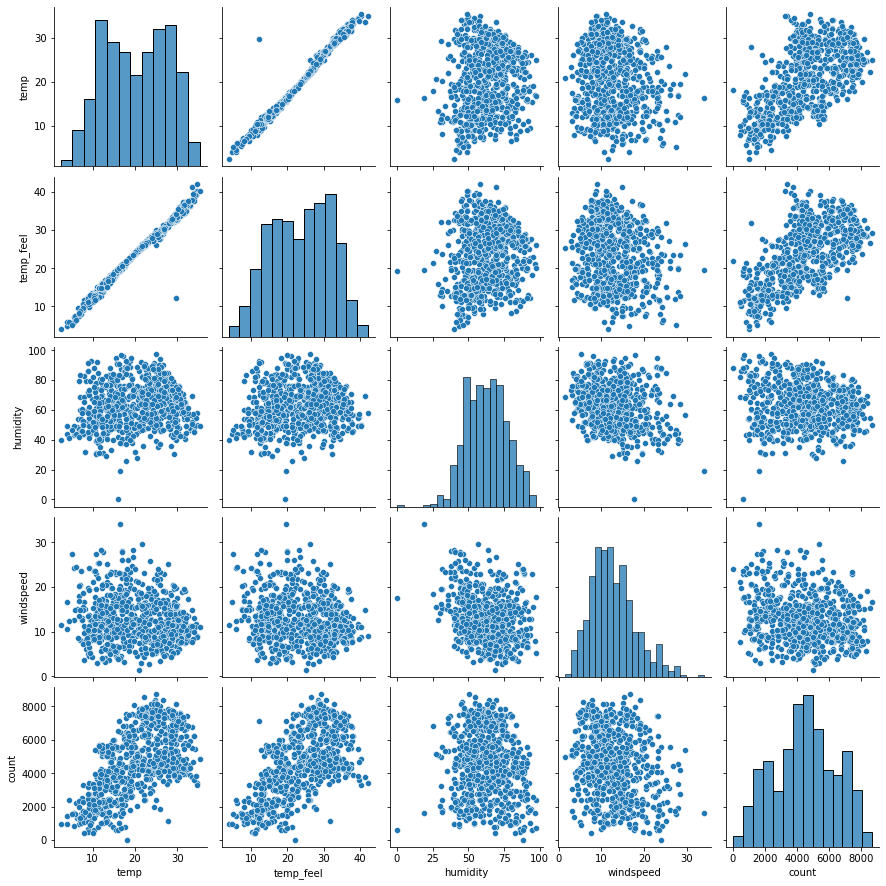

In [20]:
#visualize a pairplot for the given values
plt.figure(figsize=(16,16))
sns.pairplot(data=bike_df,vars=['temp','temp_feel','humidity','windspeed','count'])
plt.show()

##### Inference

 - The above plot shows that the columns 'temp' and 'temp_feel' are highly correlated and has a very strong linear relationship

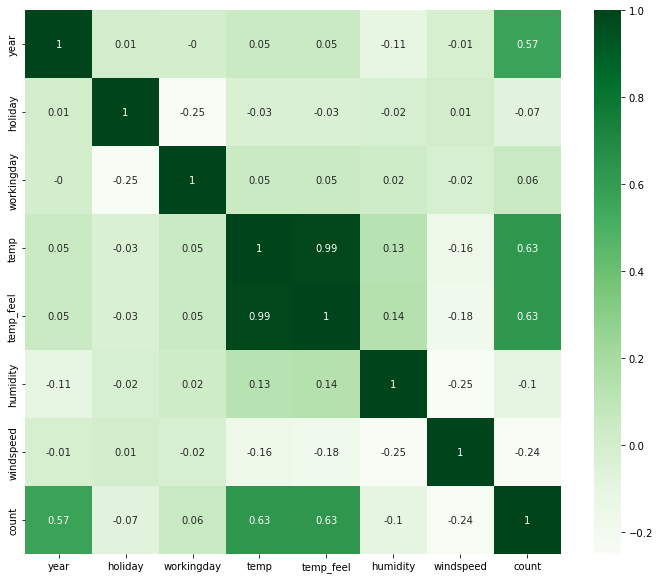

In [21]:
# A heatmap can confirm it. So, let's create a heatmap to check the correlation

plt.figure(figsize=(12,10))
sns.heatmap(bike_df.corr().round(2),cmap="Greens",annot=True)
plt.show()

So, it can be confirmed that the column 'temp_feel' and 'temp' have a very strong correlation. 

#### Preparation For Regression - 3

The following steps can be performed to a dataframe to make it a regression ready dataset

 - Creation of dummy variables for categorical columns.
 - Removal of categorical columns for which the dummy variables were created
 - Scaling of features

In [22]:
# Dummy variable creation for month, weekday, weathery_type and season variables.

df1=pd.get_dummies(bike_df.month,drop_first=True)
df2=pd.get_dummies(bike_df.weekday,drop_first=True)
df3=pd.get_dummies(bike_df.weather_type,drop_first=True)
df4=pd.get_dummies(bike_df.season,drop_first=True)

In [23]:
#concat the dataframes created above to the existing bike_df|

bike_df = pd.concat([bike_df,df1,df2,df3,df4],axis=1)

In [24]:
#Let's check the head after the concatenation

bike_df.head()

,season,year,month,holiday,weekday,workingday,weather_type,temp,temp_feel,humidity,...,sat,sun,thu,tue,wed,light rain,misty,spring,summer,winter
0,spring,0,jan,0,sat,0,misty,14.110847,18.18125,80.5833,...,1,0,0,0,0,0,1,1,0,0
1,spring,0,jan,0,sun,0,misty,14.902598,17.68695,69.6087,...,0,1,0,0,0,0,1,1,0,0
2,spring,0,jan,0,mon,1,clear,8.050924,9.47025,43.7273,...,0,0,0,0,0,0,0,1,0,0
3,spring,0,jan,0,tue,1,clear,8.200000,10.60610,59.0435,...,0,0,0,1,0,0,0,1,0,0
4,spring,0,jan,0,wed,1,clear,9.305237,11.46350,43.6957,...,0,0,0,0,1,0,0,1,0,0


We see a total of 34 columns now. 

Let's remove the base categorical columns where the dummy variables were created.

In [25]:
# dropping unnecessary columns as we have already created dummy variable out of it.

bike_df.drop(['season','month','weekday','weather_type'], axis = 1, inplace = True)

Now let's Split the data into train - test sets for further analysis

In [26]:
# splitting the dataframe into Train and Test based on the sklearn train_test_split method

np.random.seed(0)
train_df, test_df = train_test_split(bike_df, train_size = 0.8, random_state = 100)

In [27]:
#check the shape of training set

train_df.shape

(584, 30)

In [28]:
#check the shape of test dataset

test_df.shape

(146, 30)

Let's scale the features for the train set. We will use the MinMax scaling here.

In [29]:
#Scale feature using the MinMax scaling method.

sclr = MinMaxScaler()

# scale all the features except the dummy variable and 1/0 types
scale_columns = ['temp','humidity', 'temp_feel', 'windspeed','count']
train_df[scale_columns] = sclr.fit_transform(train_df[scale_columns])

In [30]:
# Describe the train_df to check if everything is rightly scaled

train_df.describe()

,year,holiday,workingday,temp,temp_feel,humidity,windspeed,count,aug,dec,...,sat,sun,thu,tue,wed,light rain,misty,spring,summer,winter
count,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,...,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000,584.000000
mean,0.513699,0.027397,0.667808,0.537414,0.513175,0.649499,0.319463,0.515792,0.090753,0.087329,...,0.150685,0.154110,0.135274,0.133562,0.154110,0.027397,0.342466,0.251712,0.246575,0.250000
std,0.500241,0.163378,0.471403,0.225336,0.211663,0.144219,0.168114,0.225336,0.287504,0.282558,...,0.358048,0.361363,0.342309,0.340472,0.361363,0.163378,0.474941,0.434369,0.431387,0.433384
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.340113,0.331819,0.535852,0.199177,0.350696,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.545191,0.530558,0.653714,0.294764,0.522837,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.736512,0.690521,0.752361,0.410413,0.691872,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.250000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Build the model - 4

Now that the scaling is done, let's use our data to build the regression model

In [31]:
# building a linear regression model

y_train = train_df.pop('count') #independent variable 
X_train = train_df 

In [32]:
# feature elimination base on RFE model

model = LinearRegression()
model.fit(X_train, y_train)

rfe = RFE(model)
rfe = rfe.fit(X_train,y_train)

In [33]:
#print the columns that have been selected

print("Columns selected: ", X_train.columns[rfe.support_])

#print the rejected columns

print("Columns rejected: ",X_train.columns[~rfe.support_])


Columns selected:  Index(['year', 'workingday', 'temp', 'humidity', 'windspeed', 'dec', 'jan',
       'july', 'nov', 'sat', 'light rain', 'misty', 'spring', 'winter'],
      dtype='object')
Columns rejected:  Index(['holiday', 'temp_feel', 'aug', 'feb', 'june', 'mar', 'may', 'oct',
       'sep', 'mon', 'sun', 'thu', 'tue', 'wed', 'summer'],
      dtype='object')


In [34]:
# method that calculates the VIF for a dataframe

def calculate_vif(df):
    vif = pd.DataFrame()
    vif['Features'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    vif = vif.reset_index(drop=True)
    return vif 

In [35]:
# building the linear regression model - model 1

cols_selected = X_train.columns[rfe.support_]
X_trn_rfe = X_train[cols_selected]
X_trn_sm = sm.add_constant(X_trn_rfe)
lr1 = sm.OLS(y_train, X_trn_sm).fit()
print(lr1.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     230.9
Date:                Tue, 11 Oct 2022   Prob (F-statistic):          6.59e-224
Time:                        16:15:11   Log-Likelihood:                 596.66
No. Observations:                 584   AIC:                            -1163.
Df Residuals:                     569   BIC:                            -1098.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3110      0.031     10.079      0.0

In [36]:
# calculate VIF for the current 

calculate_vif(X_trn_rfe)

,Features,VIF
0,humidity,25.83
1,temp,17.92
2,workingday,4.44
3,windspeed,4.23
4,spring,3.03
5,winter,2.77
6,misty,2.29
7,year,2.08
8,sat,1.77
9,jan,1.71


Though there wasn't any outlier 'P value' in the above columns, the VIF method a very high VIF for humidity(should be less than 5). So, let's drop the humidity and generate a new model

In [37]:
#dropping the humidity column

X_trn_rfe.drop(['humidity'],axis=1,inplace=True)

Let's check the VIF with the humidity column dropped

In [38]:
calculate_vif(X_trn_rfe)

,Features,VIF
0,temp,6.22
1,workingday,4.34
2,windspeed,4.23
3,spring,2.44
4,winter,2.40
5,year,2.07
6,sat,1.76
7,nov,1.65
8,jan,1.62
9,misty,1.55


The VIF is low for the columns except 'temp'. Let's generate a second model to also check the 'p values'

In [39]:
# 2nd model

X_trn_m2 = sm.add_constant(X_trn_rfe)
lr2 = sm.OLS(y_train,X_trn_m2).fit()
print(lr2.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     242.4
Date:                Tue, 11 Oct 2022   Prob (F-statistic):          2.72e-222
Time:                        16:15:15   Log-Likelihood:                 589.98
No. Observations:                 584   AIC:                            -1152.
Df Residuals:                     570   BIC:                            -1091.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2423      0.025      9.842      0.0

The VIF for 'temp' column is more than 5. So, let's drop it and calculate the VIF again.

In [40]:
#dropping the 'temp' column based on the VIF value.

X_trn_rfe.drop(['temp'],axis=1,inplace=True)

In [41]:
#calculate the VIF 

calculate_vif(X_trn_rfe)

,Features,VIF
0,windspeed,3.50
1,workingday,3.07
2,winter,2.39
3,spring,2.27
4,year,1.89
5,nov,1.63
6,jan,1.59
7,misty,1.52
8,sat,1.50
9,dec,1.40


The VIF values are all less than 5. Let's create a model with the current columns to check if there are any columns with significant 'p value'

In [42]:
#3rd model

X_trn_m3 = sm.add_constant(X_trn_rfe)
lr3 = sm.OLS(y_train,X_trn_m3).fit()
print(lr3.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     184.6
Date:                Tue, 11 Oct 2022   Prob (F-statistic):          1.59e-187
Time:                        16:15:40   Log-Likelihood:                 504.91
No. Observations:                 584   AIC:                            -983.8
Df Residuals:                     571   BIC:                            -927.0
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5325      0.015     35.451      0.0

The column 'july' shows a very high 'p value'. Let's drop it, calculate VIF and create a new model

In [43]:
X_trn_rfe.drop(['july'],axis=1,inplace=True)

In [44]:
# calculate the vif after dropping 'july'

calculate_vif(X_trn_rfe)

,Features,VIF
0,windspeed,3.49
1,workingday,3.00
2,winter,2.35
3,spring,2.22
4,year,1.88
5,nov,1.63
6,jan,1.59
7,misty,1.51
8,sat,1.48
9,dec,1.40


In [45]:
#4th model

X_trn_m4 = sm.add_constant(X_trn_rfe)
lr4 = sm.OLS(y_train,X_trn_m4).fit()
print(lr4.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     201.7
Date:                Tue, 11 Oct 2022   Prob (F-statistic):          1.12e-188
Time:                        16:15:42   Log-Likelihood:                 504.89
No. Observations:                 584   AIC:                            -985.8
Df Residuals:                     572   BIC:                            -933.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5333      0.015     36.688      0.0

The VIF values were fine but the column 'winter' still has a high 'p value'. So, let's drop it and re-run the procedure to generate a new model

In [46]:
#dropping the column 'winter'

X_trn_rfe.drop(['winter'],axis=1,inplace=True)

In [47]:
#calculate the Vif

calculate_vif(X_trn_rfe)

,Features,VIF
0,windspeed,3.47
1,workingday,2.93
2,spring,2.03
3,year,1.87
4,jan,1.58
5,misty,1.50
6,sat,1.46
7,dec,1.13
8,nov,1.10
9,light rain,1.06


In [48]:
#5th model

X_trn_m5 = sm.add_constant(X_trn_rfe)
lr5 = sm.OLS(y_train,X_trn_m5).fit()
print(lr5.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     221.4
Date:                Tue, 11 Oct 2022   Prob (F-statistic):          1.69e-189
Time:                        16:15:47   Log-Likelihood:                 504.03
No. Observations:                 584   AIC:                            -986.1
Df Residuals:                     573   BIC:                            -938.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5373      0.014     37.774      0.0

For the model 5, the 'p value' for all the columns is less than 0.05 and 'VIF' for the columns is also less than 5. So, this can be considered our final model for the training set.

Let's check the parameters for this model

In [49]:
lr5.params

const         0.537264
year          0.241756
workingday    0.062132
windspeed    -0.211200
dec          -0.120534
jan          -0.120535
nov          -0.117095
sat           0.071658
light rain   -0.314046
misty        -0.088811
spring       -0.242288
dtype: float64

In [50]:
#The important parameters for the final training set

print("===================================")
print("=========Training Model============")
print('R-squared value: 0.794')
print('Adjusted R-squared: 0.791')
print('F-statistic: 221.4')

=========Training Model============
R-squared value: 0.794
Adjusted R-squared: 0.791
F-statistic: 221.4


#### Residual Analysis - 5

Now that we have considered the model 5 as our final model, we will have to prove that the distribution of error terms is a normal distribution to confirm the model

Let's create a plot to check the distribution of the errors terms i.e.. the difference between the y predicted and y actual for the training set.

In [51]:
#using the final model to predict y values

y_pred = lr5.predict(X_trn_m5)

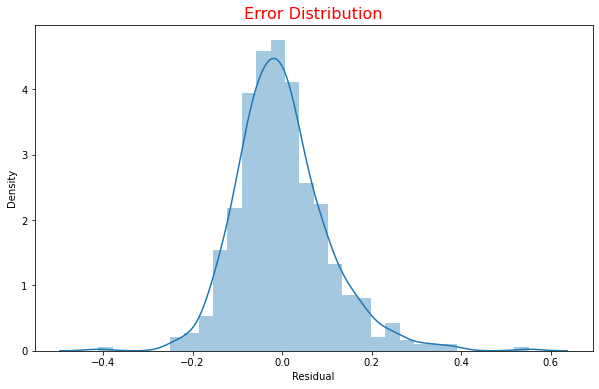

In [52]:
# Create a dist plot for the error terms of training set

plt.figure(figsize=(10,6))
residual = y_pred - y_train
sns.distplot(residual,bins=30)
plt.xlabel('Residual')
plt.title('Error Distribution', fontsize=16,color='r')
plt.show()

The plot shows that the errors are normally distributed which proves our assumption for the error terms was true

Now, let's check that the error terms are independent, which was our second assumption

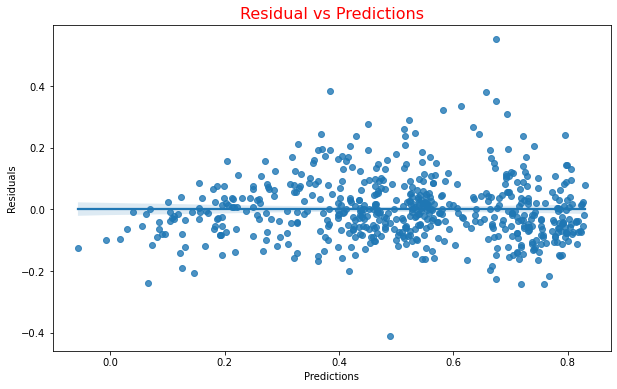

In [53]:
#check whether there is any specific pattern in the error terms

plt.figure(figsize=(10,6))
sns.regplot(x=y_pred, y=residual)
plt.title('Residual vs Predictions', fontsize=16,color='r')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()


It can be confirmed from the plot that there is no specific pattern observed in the error terms which concludes that the error terms are independent proving our assumption was true

Let's check the final assumption for Homoscedasticity i.e.. the error terms are equally distributed across predicted values

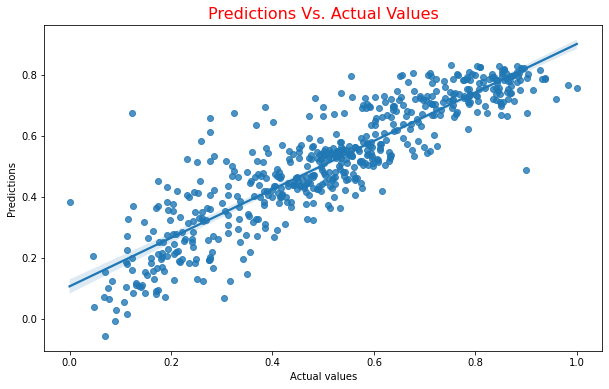

In [54]:
#check the plot for predictions vs actual values

plt.figure(figsize=(10,6))
sns.regplot(x=y_train, y=y_pred)
plt.title('Predictions Vs. Actual Values', fontsize=16,color='r')
plt.xlabel('Actual values')
plt.ylabel('Predictions')
plt.show()

The above plot confirms our final assumption of error terms being equally distributed across the predicted values to be true. 

#### Prediction of the Test data - 6

Now that the model is confirmed and the assumptions are validated, it's time to go ahead and make predictions using the model

Let's scale the columns of the test dataframe

In [55]:
# Scale the columns of the test dataframe

cols = ['temp','humidity','temp_feel','windspeed','count']
test_df[cols] = sclr.transform(test_df[cols])
test_df.head()

,year,holiday,workingday,temp,temp_feel,humidity,windspeed,count,aug,dec,...,sat,sun,thu,tue,wed,light rain,misty,spring,summer,winter
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,0,...,0,0,0,0,0,0,1,0,0,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,0,0,...,0,0,0,0,1,0,0,0,1,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,...,0,0,1,0,0,0,1,0,0,1
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,1,0,...,0,0,0,0,1,0,0,0,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,0,0,...,0,0,1,0,0,0,0,0,1,0


In [56]:
#decribe

test_df.describe()

,year,holiday,workingday,temp,temp_feel,humidity,windspeed,count,aug,dec,...,sat,sun,thu,tue,wed,light rain,misty,spring,summer,winter
count,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,...,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000,146.000000
mean,0.445205,0.034247,0.746575,0.569603,0.542752,0.635933,0.315127,0.517368,0.061644,0.075342,...,0.116438,0.102740,0.171233,0.178082,0.089041,0.034247,0.315068,0.226027,0.273973,0.219178
std,0.498699,0.182488,0.436469,0.238088,0.222120,0.156357,0.161524,0.212757,0.241335,0.264852,...,0.321854,0.304664,0.378009,0.383899,0.285783,0.182488,0.466142,0.419697,0.447530,0.415114
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.055683,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.250000,0.359075,0.346732,0.534457,0.196160,0.391251,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.560248,0.544652,0.614856,0.306383,0.508916,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.801929,0.743337,0.730570,0.411976,0.649994,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.800793,0.963300,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [57]:
y_test = test_df.pop('count')
x_test = test_df

In [58]:
cols = X_trn_rfe.columns
x_test = x_test[cols]

x_test_m5 = sm.add_constant(x_test)

#predict the y values, based on the model 5 of training set
y_test_pred = lr5.predict(x_test_m5)


In [59]:
#calculate the R-Squared value for the test dataset

r2score = r2_score(y_test, y_test_pred)
print("R-Squared for the test dataset: ",round(r2score,3))

# Calculating Adjusted-R^2 value for the test dataset

r2_adjusted = round(1-(1-r2score)*(x_test.shape[0]-1)/(x_test.shape[0]-x_test.shape[1]-1),3)
print("Adjusted R-Squared for the test dataset: ",round(r2_adjusted,3))

R-Squared for the test dataset:  0.734
Adjusted R-Squared for the test dataset:  0.714


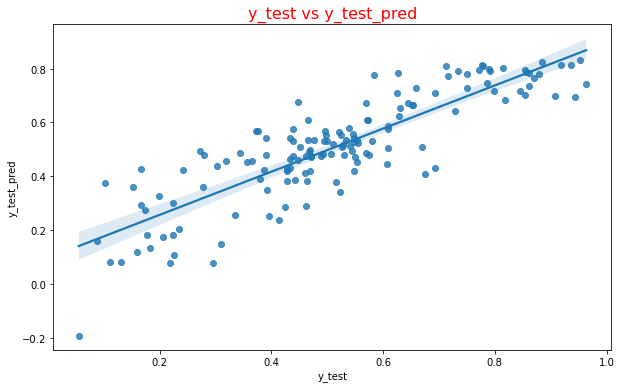

In [60]:
# Plotting y_test and y_pred to understand the spread

plt.figure(figsize=(10,6))
sns.regplot(y_test, y_test_pred)
plt.title('y_test vs y_test_pred', fontsize = 16,color='r')
plt.xlabel('y_test')
plt.ylabel('y_test_pred')
plt.show()

#### Conclusion

1. The following are the coefficients of the important features that affect our model

In [61]:
lr5.params

const         0.537264
year          0.241756
workingday    0.062132
windspeed    -0.211200
dec          -0.120534
jan          -0.120535
nov          -0.117095
sat           0.071658
light rain   -0.314046
misty        -0.088811
spring       -0.242288
dtype: float64

2. Based on this, we can say that the demand of bikes depends upon <i><b>year, workingday, windspeed, </b></i> the months <i><b>dec, jan, nov</b></i>, the day <i><b>sat</b></i>, weather condition <i><b>light rain, misty</b></i> and season <i><b>spring</b></i>